# 6공학관 층 분류하기 - AID 지옥캠프2

- 작성된 환경: Window 11, Pip, Python 3.9, CUDA 11.8, VScode
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

### 모듈
- shell에서
``` shell
# Colab 환경은 필요한 모든 모듈이 설치되어 있어 설치할 필요 x
```
``` shell
# 본인 GPU(CUDA)에 맞는 버전을 설치해주세요
# 참고: https://pytorch.org/get-started/locally/
# ex1) Pip, CPU 환경
# pip3 install torch torchvision torchaudio
# ex2) Conda, CUDA 12.4 환경
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
```shell
pip3 install -U scikit-learn
pip3 install -U matplotlib
pip3 install tqdm
```

### 데이터 파일
- 데이터 파일을 root 경로(baseline_code.ipynb가 있는 폴더)에 압축해제 해주세요
- data link: https://www.kaggle.com/datasets/hyunseok21/jiokdata
- colab 환경이라면 다음 [챕터](#colab-환경에서-kaggle파일-다운로드하기---로컬환경이라면-건너뛰기) 확인해주세요
``` shell
📁root
 ├─📁test
 ├─📁train
 │  ├─📁2F_train
 │  ├─📁3F_train
 │  ├─📁4F_train
 │  └─📁5F_train
 └─📜baseline_code.ipynb
```

# Train Data로 학습하기

## 모델 학습 (with train data)

### 모듈 불러오기

In [ ]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA GeForce RTX 4070 SUPER
2.5.1
12.4
tensor([-0.4881], device='cuda:0')


device(type='cuda', index=0)

### 하이퍼 파라미터 (Hyper Parameter)

In [ ]:
params = {
  # For Train
  'epoch': 100,
  'batch_size': 16,

  # CPU worker
  'workers': 8, # 본인 cpu 쓰레드의 절반 정도

  # imgShow
  'num_show_img': 5, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음

  # For Optimizer
  'learning_rate': 0.001,
}

### 저장할 학습 완료 모델 파일 이름

In [ ]:
pt_file_name = 'model.pt'

### 데이터 라벨링

In [ ]:
class_names = {
  "0": "2F",
  "1": "3F",
  "2": "4F",
  "3": "5F",
}

### 데이터 전처리

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. 데이터 전처리 정의
train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
    ]),
    transforms.Resize((224, 224)),  # Ensure all images are resized to [224, 224]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. 데이터 로드 (두 개의 데이터셋 생성)
dataset_train = datasets.ImageFolder(root='../train', transform=train_transforms)
dataset_val = datasets.ImageFolder(root='../train', transform=val_transforms)

# 3. 데이터셋 분리
all_indices = list(range(len(dataset_train)))
labels = dataset_train.targets

train_idx, tmp_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

val_idx, test_idx = train_test_split(
    tmp_idx,
    test_size=0.5,
    random_state=42,
    stratify=[labels[i] for i in tmp_idx]
)

# 4. Subset 생성
subset_train = Subset(dataset_train, train_idx)
subset_valid = Subset(dataset_val, val_idx)
subset_test = Subset(dataset_val, test_idx)

# 5. DataLoader 정의
dataloaders = {
    'train': DataLoader(
        subset_train,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=params['workers'],
        pin_memory=True
    ),
    'valid': DataLoader(
        subset_valid,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=params['workers'],
        pin_memory=True
    ),
    'test': DataLoader(
        subset_test,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=params['workers'],
        pin_memory=True
    )
}

### Train 함수

In [ ]:
def train_model(model, criterion, optimizer, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1
      #Iterate over data.
      pbar_dataloaders = tqdm(dataloaders[phase],
                              desc=phase,
                              ncols=70)
      for inputs, labels in pbar_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_cnt += len(labels)
        count += 1
      pbar_dataloaders.close()

      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch + 1
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: idx=%d , %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), pt_file_name)
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### 모델 구성

In [ ]:
# class BaseModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, stride=1, padding=0)

#         self.fc1 = nn.Linear(4 * 224 * 224, 8)
#         self.fc2 = nn.Linear(8, 4)

#     def forward(self, x):
#         # Weak activation with minimal learning capacity
#         x = F.sigmoid(self.conv1(x))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = F.sigmoid(self.fc1(x))
#         x = self.fc2(x)
#         return x


### 데이터 확인

In [ ]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

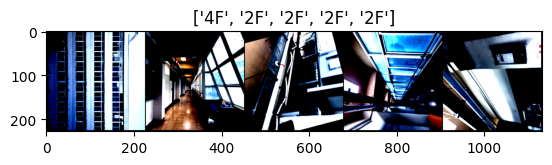

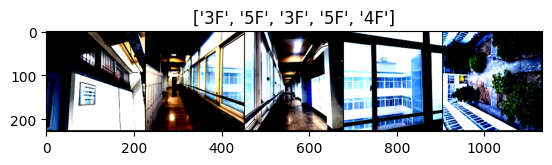

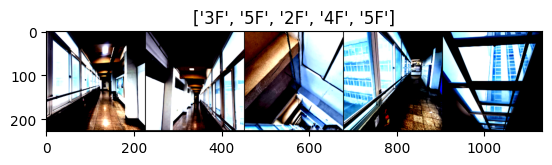

In [ ]:
# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [ ]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)

num_classes = 4  # 예측할 클래스 수
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if next(model.parameters()).is_cuda:
  print("Model to CUDA")
else:
  print("Model to CPU")

Model to CUDA


c:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 손실함수 & 옵티마이저

In [ ]:
# 손실함수
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(),
                            lr=params['learning_rate'],
                          )

### 학습 시작

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, dataloaders, num_epochs=params['epoch'])

## 학습 결과 분석

In [ ]:
## 결과 그래프 그리기
print('best model info:\nModel extracted from epoch %d\nValid Acc=%1.f / Valid Loss=%.1f'%(best_idx, valid_acc[best_idx-1], valid_loss[best_idx-1]))
fig, ax1 = plt.subplots()

ax1.plot([n for n in range(1,len(train_acc)+1)], train_acc, 'b-', label='train acc')
ax1.plot([n for n in range(1,len(valid_acc)+1)], valid_acc, 'r-', label ='valid_acc')
plt.plot(best_idx, valid_acc[best_idx-1], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot([n for n in range(1,len(train_loss)+1)], train_loss, 'g-', label='train loss')
ax2.plot([n for n in range(1,len(valid_loss)+1)], valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx-1], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

NameError: name 'best_idx' is not defined

## 모델 TEST

In [ ]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size

    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())],
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])

      if i == 0: break

  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 1.43 / 28.6


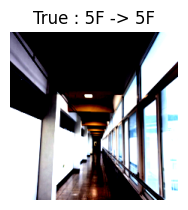

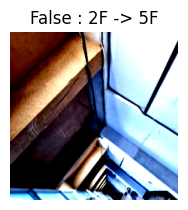

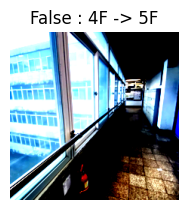

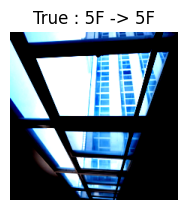

In [ ]:
test_and_visualize_model(model, dataloaders, phase='test')

# Test 데이터 분류 및 CSV 만들기

In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys

In [ ]:
data_path = './test'
image_files = sorted(glob.glob(data_path + '/*'))
csv_filename = 'answer.csv'

os_name = sys.platform
path_split = '/'
if os_name.startswith('win'):
  path_split = '\\'

In [ ]:
class TestImageDataset(Dataset):
  def __init__(self, files, transform):
    super().__init__()
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    try:
        img = Image.open(file).convert('RGB')
    except Exception as e:
        print(f"Error opening image {file}: {e}")
        raise
    img = self.transform(img)

    return img, file.split(path_split)[-1]

In [ ]:
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), # 224x224 사이즈로 변환
                        transforms.ToTensor(), # 텐서화
                      ])

In [ ]:
test_dataset = TestImageDataset(image_files, test_transform)

In [ ]:
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=False,
                         )

In [ ]:
model_dict = torch.load(pt_file_name, map_location=device)
trained_model = efficientnet_b0(pretrained=True)

num_classes = 4  # 예측할 클래스 수
trained_model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
trained_model.load_state_dict(model_dict)
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

CUDA:True


C:\Users\ryong\AppData\Local\Temp\ipykernel_11992\696740188.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(pt_file_name, map_location=device)
c:

In [ ]:
def test_and_make_csv(model, dataloader):
  # phase = 'train', 'valid', 'test'

  model.eval()

  answer_csv = 'id,floor\n'

  pbar_dataloaders = tqdm(dataloader,
                          desc='Making Csv',
                          ncols=70)
  with torch.no_grad():
    for inputs, filenames in pbar_dataloaders:
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(len(preds)):
        answer_csv += f'{filenames[j].split(".")[0]},{class_names[str(preds[j].cpu().numpy())]}\n'
  pbar_dataloaders.close()

  with open(csv_filename, 'w') as file:
    file.write(answer_csv)
    print(f'{csv_filename}가 생성되었습니다.')

In [ ]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 0it [00:00, ?it/s]

answer.csv가 생성되었습니다.
